# PSF/PRF Photometry on Spitzer Data

The affiliated package *photutils* offers now some basic functions to perform PSF/PRF photometry on astronomical image data. In this notebook I'd like to give a short introduction on the basis of a Spitzer data set.

### Introduction

As an improvement, compared to aperture photometry, PSF photometry makes use of instrument related information. To estimate the 
the physical parameters of an astrophysical point source it uses a model how this point souce is imaged by the instrument.
This model is called point spread function (PSF). The PSF can be either obtained from the data itself or modeled by some analytical
function. Additionally there is a second concept, the so called point response function (PRF), which denotes the PSF after discretization with a CCD. We are going to deal mostly with PRFs.

### Preparing the data

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.table import Table
from astropy.io import fits
from astropy.wcs import wcs
import astropy.units as u

At first we use `astropy.table` to read the coordinates and fluxes for the sources from the catalog:

In [11]:
catalog = Table.read("../data/spitzer_example_catalog.xml")
l = catalog['l']
b = catalog['b']
fluxes_catalog = catalog['f4_5']

We read the image data using `astropy.io.fits`. As the image data is given in `MJy/sr`, but in the catalog the units are `mJy`, we have to convert the units. Therefore we use that the image data has a resolution of `(1.2 arcsec)^2 / pixel`. Furthermore we set up a mask to exclude NaN values.

In [12]:
data = fits.getdata('../data/spitzer_example_image.fits')
factor = (u.MJy / u.sr * (1.2 * u.arcsec) ** 2 / u.pixel).to(u.mJy / u.pixel)
data *= factor.value
mask = np.isfinite(data)

As the photometry function is currently only able to handle pixel coordinates, we define a WCS transformation to convert the galactic coordinates into pixel coordinates:

In [13]:
header = fits.getheader('../data/spitzer_example_image.fits')
wcs_transform = wcs.WCS(header)
coords = wcs_transform.wcs_world2pix(zip(l, b), 0)

# It seems that the coordinates are shifted. To have the PRF images properly aligned in the plot below, we correct for this.
coords.T[0] += 0.18
coords.T[1] += 0.3

Here is a plot with the source positions overlayed:

<matplotlib.colorbar.Colorbar instance at 0xaded50c>

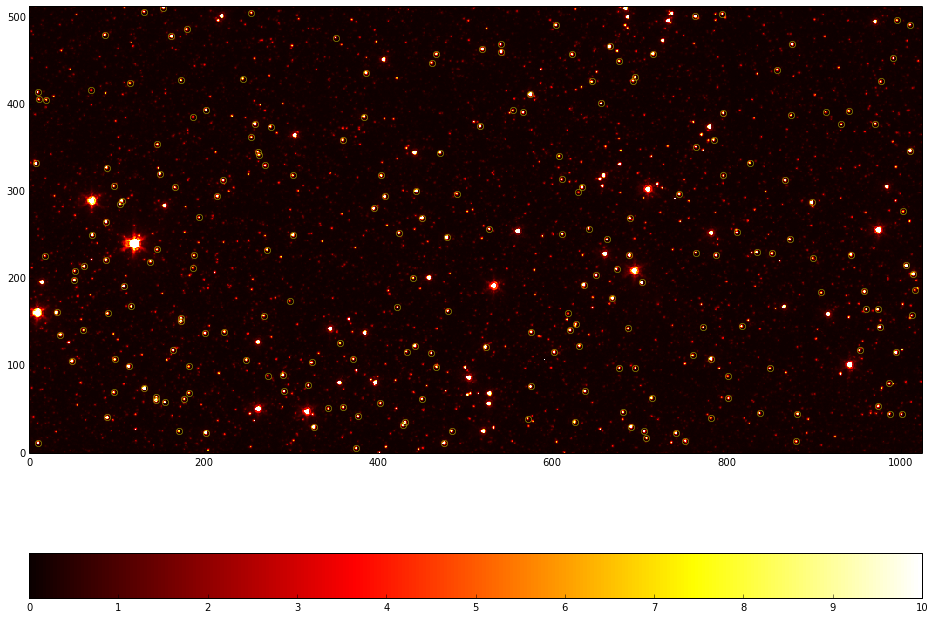

In [14]:
plt.figure(figsize=(16, 12))
plt.imshow(data, cmap='hot', vmin=0, vmax=10, interpolation='None', origin='lower')
plt.xlim(0, 1024)
plt.ylim(0, 512)
plt.plot(coords.T[0], coords.T[1], marker="o", markerfacecolor='None', markeredgecolor='y', linestyle='None')
plt.colorbar(orientation='horizontal')

Now we're ready to estimate the PRF from the data.

### Creating PRFs from image data

To estimate the PRF we work on the complete dataset. We choose a size of 7 pixels and a subsampling of 5 / pixel for the PRF.

In [15]:
from photutils.psf import create_prf

prf_discrete = create_prf(data, coords, 7, fluxes=fluxes_catalog, mask=np.logical_not(mask), subsampling=5)

Furthermore we measure the runtime:

In [16]:
%timeit -n 3 create_prf(data, coords, 7, fluxes=fluxes_catalog, mask=np.logical_not(mask), subsampling=5)

3 loops, best of 3: 129 ms per loop


The object returned by `create_prf` is a `DiscretePRF` object, which is basically a look-up table of the different PRFs at different subpixel positions. But it behaves and can be handled like a usual `astropy.modeling.ParametricModel`. The PRFs are stored in the `DiscretePRF._prf_array` attribute. We make a plot to illustrate this:

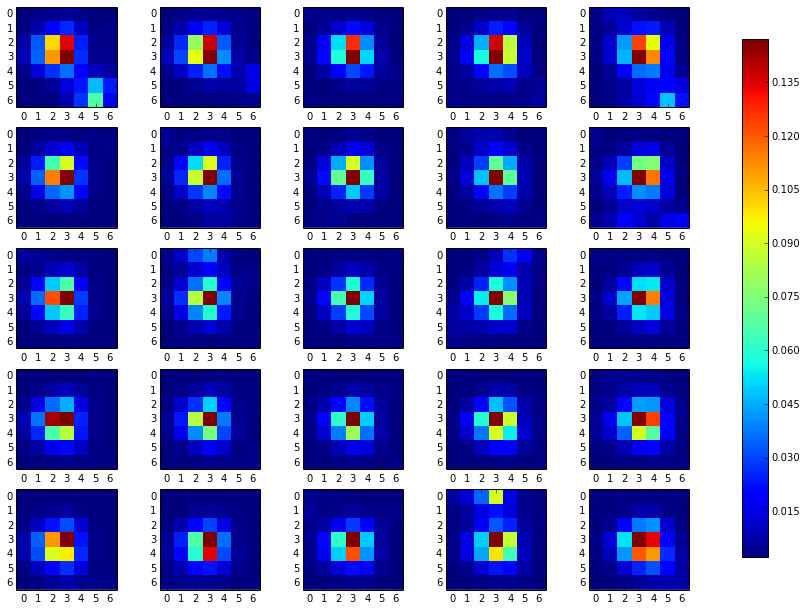

In [17]:
fig, axes = plt.subplots(nrows=5, ncols=5)
fig.set_size_inches(12, 9)
# Plot kernels
for i in range(5):
    for j in range(5):
        prf_image = prf_discrete._prf_array[i, j]
        im = axes[i, j].imshow(prf_image, interpolation='None')
			
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
plt.colorbar(im, cax=cax)
plt.subplots_adjust(left=0.05, right=0.85, top=0.95, bottom=0.05)
plt.show()

As we work on a reduced dataset the PRF images at the boundaries show a few artifacts due to bad statistics. A better handling of outliers could be achieved by setting `mode = 'median'` in the `create_prf` function or reducing the size of the prf.

### Photometry with DiscretePRF

We perform photometry on the first 500 sources of the dataset:

In [18]:
from photutils.psf import psf_photometry
fluxes_photutils = psf_photometry(data, coords, prf_discrete)

To compare with the catalog results, we make a scatter plot:

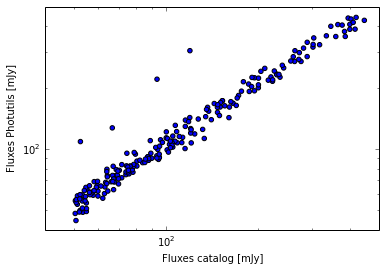

In [19]:
plt.scatter(fluxes_catalog, fluxes_photutils)
plt.loglog()
plt.xlim(40, 500)
plt.ylim(40, 500)
plt.xlabel("Fluxes catalog [mJy]")
plt.ylabel("Fluxes Photutils [mJy]")


### Photometry with GaussianPSF

We can also perform photometry using a `GaussianPSF`:

In [20]:
from photutils.psf import GaussianPSF
psf_gaussian = GaussianPSF(1)
fluxes_gaussian = psf_photometry(data, coords, psf_gaussian)

In [21]:
# Measure runtime
%timeit -n 3 psf_photometry(data, coords, psf_gaussian)

3 loops, best of 3: 1.26 s per loop


Again we compare with the catalog:

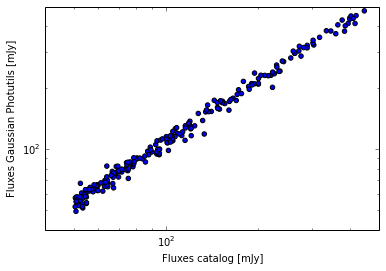

In [22]:
plt.scatter(fluxes_catalog, fluxes_gaussian)
plt.loglog()
plt.xlim(40, 500)
plt.ylim(40, 500)
plt.xlabel("Fluxes catalog [mJy]")
plt.ylabel("Fluxes Gaussian Photutils [mJy]")

### Making residual images

It is also possible to remove PRFs from the data and make residual images:

In [23]:
from photutils.psf import subtract_psf
residuals = subtract_psf(data.copy(), prf_discrete, coords, fluxes_photutils)

In [24]:
# Measure runtime
%timeit -n 3 subtract_psf(data.copy(), prf_discrete, coords, fluxes_photutils)

3 loops, best of 3: 55.7 ms per loop


We make a plot of the residual image:

<matplotlib.colorbar.Colorbar instance at 0xba5c0ec>

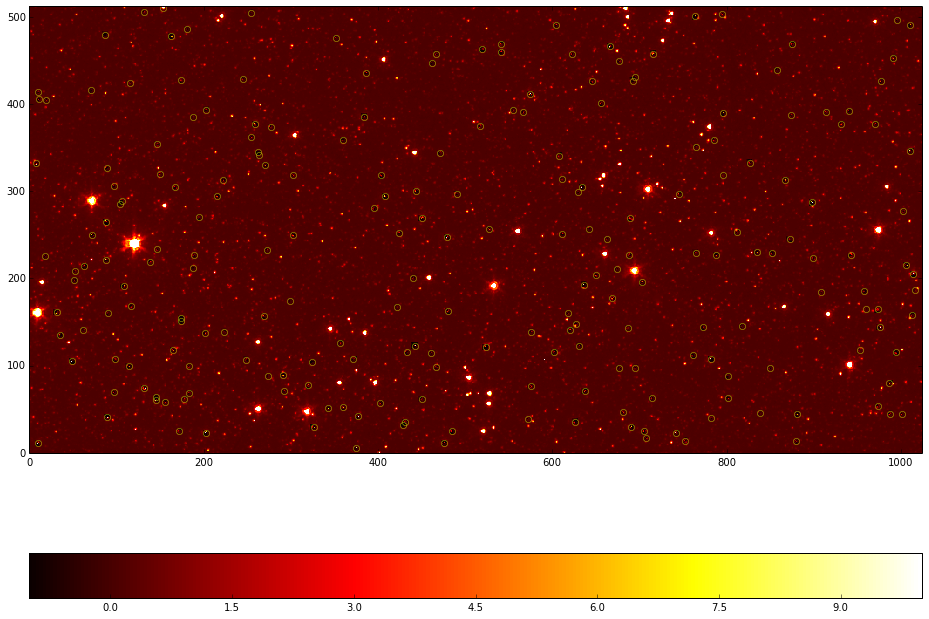

In [25]:
plt.figure(figsize=(16, 12))
plt.imshow(residuals, cmap='hot', vmin=-1, vmax=10, interpolation='None', origin='lower')
plt.plot(coords.T[0], coords.T[1], marker="o", markerfacecolor='None', markeredgecolor='y', linestyle='None')
plt.xlim(0, 1024)
plt.ylim(0, 512)
plt.colorbar(orientation='horizontal')